In [1]:
import copy
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from scipy import stats

pandarallel.initialize(progress_bar=True)

import ajf_plts
import BeamWithSprings as bm

plt.style.use(["./ajf_plts/base.mplstyle", "./ajf_plts/legend_frame.mplstyle"])

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Load result data

In [2]:
run_id = "LB_all_delta"
locs = ["L", "R"]

res_df = pd.read_parquet(f"./{run_id}").loc[
    :,
    [
        "delta",
        "seq_month",
        "year",
        "month",
        "day",
        "hour",
        "minute",
        "dayofweek",
        "air_temperature",
        "AxleCount",
        "x_dam",
        "L",
        "R",
    ],
]

res_df.delta = res_df.delta.astype(float)
res_df.year = res_df.year.astype(int)

res_df = res_df.sort_values(["delta", "seq_month", "day", "hour", "minute"])

In [13]:
axle_nums = [np.arange(2, 7), np.arange(5, 6), np.arange(6, 7)]
axle_names = ["All", "5ax", "6ax"]

baseline = res_df[(res_df.seq_month < 12) & (res_df.delta == 0.0)]


def calc_emd(df):
    if df.year.min() == 0:
        return dict(
            zip(
                [l + "_" + n for n in axle_names for l in locs],
                [np.nan] * len(locs) * len(axle_names),
            )
        )
    elif len(df.seq_month.unique()) < 12:
        return dict(
            zip(
                [l + "_" + n for n in axle_names for l in locs],
                [np.nan] * len(locs) * len(axle_names),
            )
        )
    return dict(
        zip(
            [l + "_" + n for n in axle_names for l in locs],
            [
                stats.wasserstein_distance(
                    baseline.loc[baseline.AxleCount.isin(axles), l].values,
                    df.loc[df.AxleCount.isin(axles), l].values,
                )
                for axles in axle_nums
                for l in locs
            ],
        )
    )

In [14]:
emd_vals = res_df.groupby(["delta", "year"]).parallel_apply(calc_emd)
emd_df = pd.DataFrame(
    emd_vals.to_list(),
    index=emd_vals.index,
)
emd_df = emd_df.dropna()

In [35]:
emd_dfs = []
temp_res_df = res_df.copy()

for offset in np.arange(12):
    temp_res_df.year = (temp_res_df.seq_month - offset) // 12

    emd_vals = temp_res_df.groupby(["delta", "year"]).parallel_apply(calc_emd)
    emd_df = pd.DataFrame(
        emd_vals.to_list(),
        index=pd.MultiIndex.from_tuples(
            list(
                zip(
                    emd_vals.index.get_level_values(0),
                    emd_vals.index.get_level_values(1) + offset / 12.0,
                )
            ),
            names=emd_vals.index.names,
        ),
    )
    emd_dfs.append(emd_df.dropna())
emd_df = pd.concat(emd_dfs)

In [36]:
emd_df = emd_df.sort_index()

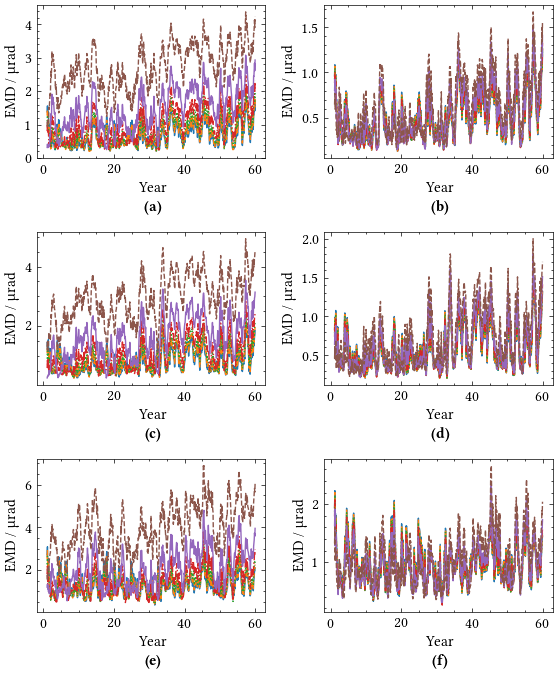

In [37]:
%matplotlib widget

fig, axes = plt.subplots(
    figsize=(ajf_plts.text_width_inches, 3.0 * ajf_plts.fig_height_inches),
    ncols=2,
    nrows=3,
)
axes = axes.ravel()

for delta, group in emd_df.groupby("delta"):
    props = dict(ls="", marker=".")
    props = dict()
    for ax, (row, emds) in zip(axes, group.T.iterrows()):
        ax.plot(emds.droplevel(0).index.values[1:], emds.values[1:] * 1e6, **props)

for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel(r"EMD / \unit{\micro\radian}")

ajf_plts.caption_axes(axes)
fig.tight_layout()

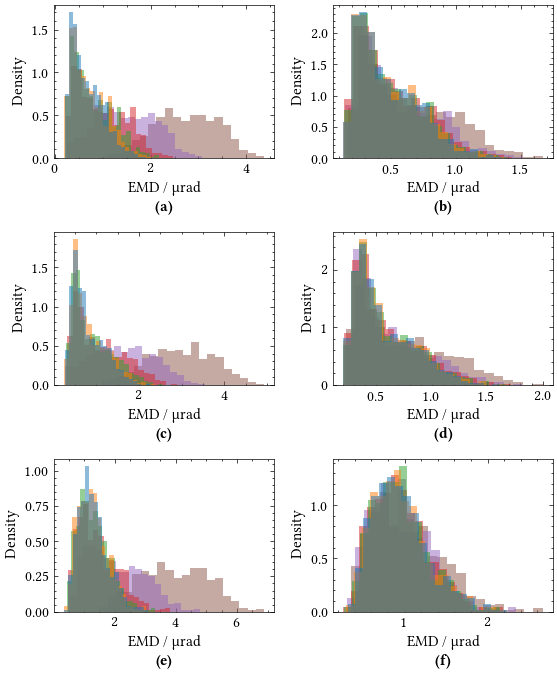

In [39]:
%matplotlib widget

fig, axes = plt.subplots(
    figsize=(ajf_plts.text_width_inches, 3.0 * ajf_plts.fig_height_inches),
    ncols=2,
    nrows=3,
)
axes = axes.ravel()

for delta, group in emd_df.groupby("delta"):
    props = dict(bins=20, density=True, alpha=0.5, zorder=100 - 100 * delta)
    for ax, (row, emds) in zip(axes, group.T.iterrows()):
        ax.hist(emds.values[1:] * 1e6, **props)

for ax in axes:
    ax.set_xlabel(r"EMD / \unit{\micro\radian}")
    ax.set_ylabel(r"Density")

ajf_plts.caption_axes(axes)
fig.tight_layout()

In [40]:
emd_cols = [f"{l}_{n}" for n in axle_names for l in locs]

In [44]:
for delta, group in emd_df.groupby("delta"):
    print(f"delta={delta:1.3f}")
    print(f"-----------")
    for col in emd_cols:
        res = stats.ks_2samp(
            emd_df.loc[0.0, col].values,
            group.loc[:, col].values,
            alternative="greater",  # describes CDF so greater means x < y as F(x) > F(y)
        )
        print(
            f"{col}: p={res.pvalue:0.3f} {'reject H0 (x=y) and accept H1 (x<y)' if res.pvalue < alpha else 'cannot reject H0 (x=y)'}"
        )
    print()

delta=0.000
-----------
L_All: p=1.000 cannot reject H0 (x=y)
R_All: p=1.000 cannot reject H0 (x=y)
L_5ax: p=1.000 cannot reject H0 (x=y)
R_5ax: p=1.000 cannot reject H0 (x=y)
L_6ax: p=1.000 cannot reject H0 (x=y)
R_6ax: p=1.000 cannot reject H0 (x=y)

delta=0.010
-----------
L_All: p=0.039 reject H0 (x=y) and accept H1 (x<y)
R_All: p=0.788 cannot reject H0 (x=y)
L_5ax: p=0.281 cannot reject H0 (x=y)
R_5ax: p=0.843 cannot reject H0 (x=y)
L_6ax: p=0.665 cannot reject H0 (x=y)
R_6ax: p=0.843 cannot reject H0 (x=y)

delta=0.025
-----------
L_All: p=0.000 reject H0 (x=y) and accept H1 (x<y)
R_All: p=0.414 cannot reject H0 (x=y)
L_5ax: p=0.001 reject H0 (x=y) and accept H1 (x<y)
R_5ax: p=0.505 cannot reject H0 (x=y)
L_6ax: p=0.074 cannot reject H0 (x=y)
R_6ax: p=0.869 cannot reject H0 (x=y)

delta=0.050
-----------
L_All: p=0.000 reject H0 (x=y) and accept H1 (x<y)
R_All: p=0.074 cannot reject H0 (x=y)
L_5ax: p=0.000 reject H0 (x=y) and accept H1 (x<y)
R_5ax: p=0.178 cannot reject H0 (x=y)
